# Mitigate Communication Barrier! Recognise American Sign Language using Neural Networks and Deep Learning Image Classification

### CS5242 Neural Network and Deep Learning Project Report
### Authors: Liu Jialin | Mansi Agarwal | Nishtha Malhotra


___

Google drive link containing all project materials: https://drive.google.com/drive/folders/100M7KY2kc9P0lUOnC1mKch5Dc_IJX3rK?usp=sharing 
___

## Report Contents:

* **1 Introduction**
    * 1.1 Motivation
    * 1.2 Problem Statement
    * 1.3 Challenges

* **2 Data**
    * 2.1 Collection and cleaning
    * 2.2 Data loading, exploration, pre-processing
    * 2.3 Data augmentation

* **3 Modelling and experimentation**
    * 3.1 Modelling methodology
    * 3.2 MLP
        * 3.2 a) Model architecture
        * 3.2 b) Iterative experiments and rationale
        * 3.2 c) Best model, model configuration and results

    * 3.3 RNN
        * 3.3 a) Model architecture
        * 3.3 b) Iterative experiments and rationale
        * 3.3 c) Best model, model configuration and results

    * 3.4 CNN
        * 3.4 a) Baseline CNN Model
        * 3.4 b) CNN Model with Augmented Data
        * 3.4 c) AlexNet CNN Architecture
        * 3.4 d) AlexNet CNN Architecture with Augmented Data
        * 3.4 e) Best model, model configuration and results

* **4 Project Initiatives and Conclusion**

* **5 Future Developments**

* **6 References**

___


# 1 Introduction

## 1.1 Project Motivation

Hearing loss is widespread, according to WHO nearly 430 million people suffer from deafness or hearing loss[1]. The Singapore Association for the Deaf (SADeaf) estimates 500,000 people suffer with hearing loss in this country but only 1800 have registered to know sign language[2]. Sign Language instruction and specialized education programs can mitigate impacts of hearing loss for young children and their families. With real-time translation of hand gestures to text over video conferencing in the long run[3], automatic Sign Language recognition systems can facilitate educational resources, create work opportunities, and foster friendly professional environments for the target community. Our work intends to mitigate the communication barrier between deaf/hard-of-hearing communities with First Responders and abled communities. 

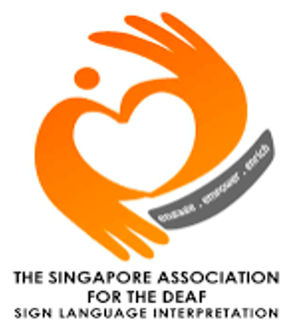


## 1.2 Problem Statement

**Build Supervised Learning American Sign Language (ASL) Recogniser System using deep neural networks capable of classifying static hand gesture images into corresponding 10 digit labels**

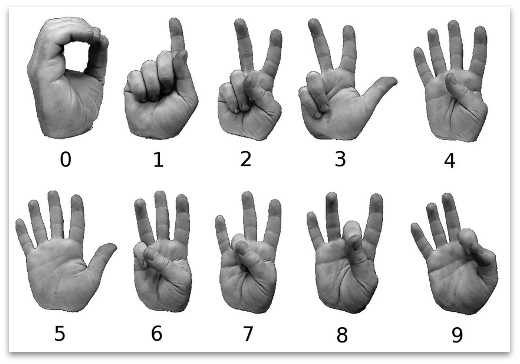


## 1.3 Challenges

Automatic Sign Language Recognition Systems are challenging to build because:
- Multimodal: Signs are characterized by hand shapes, movements, facial expressions, body posters, the multimodal nature of this problem makes it difficult to build robust systems [4],[5]
- Similar Signs for different characters such as clenched fist for alphabets A, E, M, N, S, T [9] or Similar signs for characters pairs ‘2’ | ‘V’ and ‘O’ | ‘0’
- Variations due to orientations, variety of shape and size of hands of different people
- Characters such as 'J' and 'Z' are identified by the uniqueness of movement in the hand. These characters with dynamic hand gestures cannot be recognised by static image recognition systems

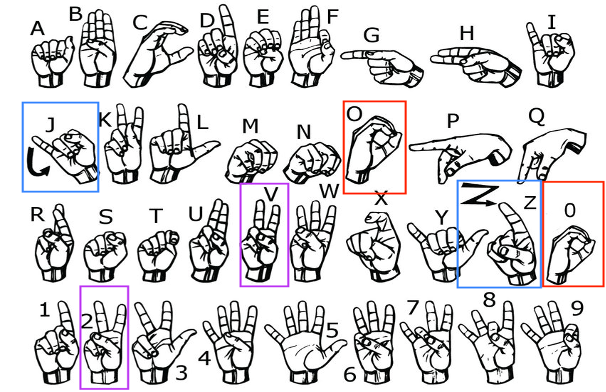

# Importing necessary packages and libraries

In [ ]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize, rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from tqdm import tqdm

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# for evaluating result
from sklearn.metrics import pair_confusion_matrix

import os
import glob
import time

torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')

print("Packages imported...")

Mounted at /content/drive/
Packages imported...


# 2 Data

## 2.1 Data collection and cleaning

All of the labelled data used in our project is scrapped from 3 sources namely, Google[6], GettyImages[7] and iStockPhoto[8]. 

We developed 3 scrappers for each of the sources. For iStockPhoto and gettyimages we used python's Beautiful soup package to crawl and save the images from their html webpages. And for Google images, we used the Google API images-scrapper. 

By providing the scrappers with different url links for each hand sign class, we can auto-save images in their respective labelled folders. In total, we have 11,440 raw images.​

However, not all 11,440 images can be used. Majority of them are not sign languages and to narrow the scope of this research on Deep neural network development, alphabets were removed. After cleaning noisy and alphabet images, we have 722 images for model development.

We stored these images in google drive.



## 2.2 Data Loading, exploration and pre-processing

From the 722 cleaned images, we randomly selected 50 images to be used in the testing test (5 for each digit) and only human hands are used. This is because our use case is breaking down communication barrier between humans, so ability to do human hands detection is more relevant. 

The rest of the 672 images are used in training.

The codes below shows the data transformation steps done on both train and test data. 
- We made it easily configurable to resize the images into different resolutions for experimentation. 
- Crop images from center
- Reduce images ot single channel using GrayScale() function
- convert image to numpy array, scale from 0 to 1 and normalise the array

In [ ]:
# transforms.ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 

size=112
train_data_transforms_original = transforms.Compose([transforms.Resize(size),
                                                      transforms.CenterCrop(size),
                                                      transforms.Grayscale(),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize((0.485), (0.224))
                                                     ])

val_data_transforms = transforms.Compose([transforms.Resize(size),
                                            transforms.CenterCrop(size),
                                            transforms.Grayscale(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485), (0.224))
                                            ])

In [ ]:
image_datasets_train = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_original)


image_datasets_test = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/test_human/", transform=val_data_transforms)


In [ ]:
train_dataloaders = DataLoader(image_datasets_train, batch_size=672, shuffle=True, num_workers=2)
test_dataloaders = DataLoader(image_datasets_test, batch_size=50, shuffle=False, num_workers=2)

In [ ]:
print("train dataset before augmentation: ", len(image_datasets_train))

train dataset before augmentation:  672


In [ ]:
print("test dataset size: ", len(image_datasets_test))

test dataset size:  50


In [ ]:
# training labels array
for b, (X_train, y_train) in enumerate(train_dataloaders):
  y_train = y_train.numpy()

In [ ]:
# get training labels count
unique, counts = np.unique(y_train, return_counts=True)

result = np.column_stack((unique, counts)) 

labels_count = result.transpose()

df = pd.DataFrame()
df["label"] = result.transpose()[0]
df["count"] = result.transpose()[1]

df

,label,count
0,0,10
1,1,81
2,2,165
3,3,37
4,4,42
5,5,139
6,6,47
7,7,18
8,8,18
9,9,115


We observe that the dataset is imbalanced. There are fewer samples for 0, 7 and 8. We will look at how these classes perform in the test set in future sections.

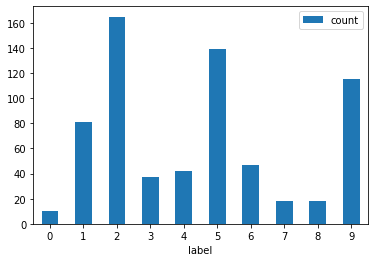

In [ ]:
ax = df.plot.bar(x='label', y='count', rot=0)

## 2.3 Data augmentation

The training dataset contains only 672 images which is a very small volume of data. 

The aim of data augmentation is increase the size and the diversity of images present in the dataset and train a robust model.

We performed data augmentation of horizontal flip, gaussian noise and random erasing. These helped to increase our training sample size. The horizontal flip also helps to capture the image of sign language on left hand and right hand which will help the model to identify the sign regardless which hand it is. 

In [ ]:
# Step 0: define transformation 
size = 28
train_data_transforms_original = transforms.Compose([transforms.Resize(size),
                                                     transforms.CenterCrop(size),
                                                     transforms.Grayscale(),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize((0.485), (0.224))
                                                     ])

train_data_transforms_with_horizontal_flip = transforms.Compose([transforms.Resize(size),
                                                                 transforms.CenterCrop(size),
                                                                 transforms.Grayscale(),
                                                                 transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.485), (0.224))
                                                                 ])

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_data_transforms_with_gaussian_noise_orginal = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.Grayscale(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485), (0.224)),
                                                                  AddGaussianNoise(0.1, 0.08),])

train_data_transforms_with_gaussian_noise_flipped = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.Grayscale(),
                                                                  transforms.RandomHorizontalFlip(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485), (0.224)),
                                                                  AddGaussianNoise(0.1, 0.08),])

train_data_transforms_with_random_erasing = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.Grayscale(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485), (0.224)),
                                                                  transforms.RandomErasing(),])




val_data_transforms = transforms.Compose([transforms.Resize(size),
                                            transforms.CenterCrop(size),
                                            transforms.Grayscale(),
                                            transforms.ToTensor()])


In [ ]:
# Step 1 : Load the datasets with ImageFolder
train_data = []
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_original))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_horizontal_flip))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_gaussian_noise_orginal))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_gaussian_noise_flipped))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_random_erasing))
image_datasets_train = torch.utils.data.ConcatDataset(train_data)


image_datasets_test = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/test_human/", transform=val_data_transforms)


In [ ]:
# Step 2: Using the image datasets and the transforms, define the dataloaders
train_batch_size = 32
train_dataloaders = DataLoader(image_datasets_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloaders = DataLoader(image_datasets_test, batch_size=50, shuffle=False, num_workers=2)

In [ ]:
print("train dataset after augmentation: ", len(image_datasets_train))

train dataset after augmentation:  3360


In [ ]:
print("train dataset after augmentation: ", len(image_datasets_test))

train dataset after augmentation:  50


Shape:  torch.Size([1, 28, 28]) 
label:  0


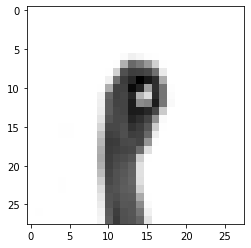

In [ ]:
image, label = image_datasets_train[0]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image.reshape((28,28)), cmap="gray")

Shape:  torch.Size([1, 28, 28]) 
label:  0


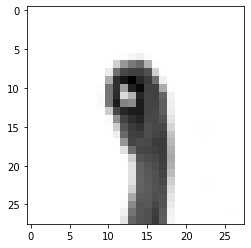

In [ ]:
image, label = image_datasets_train[672]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image.reshape((28,28)), cmap="gray")

Shape:  torch.Size([1, 28, 28]) 
label:  0


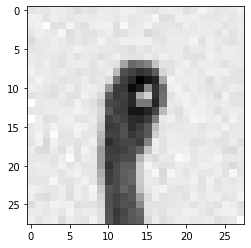

In [ ]:
image, label = image_datasets_train[1344]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image.reshape((28,28)), cmap="gray")

Shape:  torch.Size([1, 28, 28]) 
label:  0


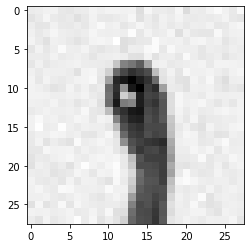

In [ ]:
image, label = image_datasets_train[2016]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image.reshape((28,28)), cmap="gray")

Shape:  torch.Size([1, 28, 28]) 
label:  0


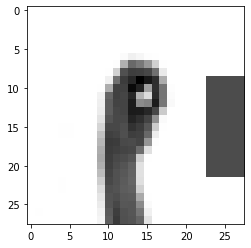

In [ ]:
image, label = image_datasets_train[2688]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image.reshape((28,28)), cmap="gray")

# 3 Modelling and Experimentation

## 3.1 Modelling methodolody

Now that we have the transformed images. These data will then be used build baseline image classification models using MLP, RNN and CNN. ​

​For each of these models, we will iteratively make improvements through data augmentation and hyperparameter tuning. ​

​
Finally we will compare and evaluate between the best models.​

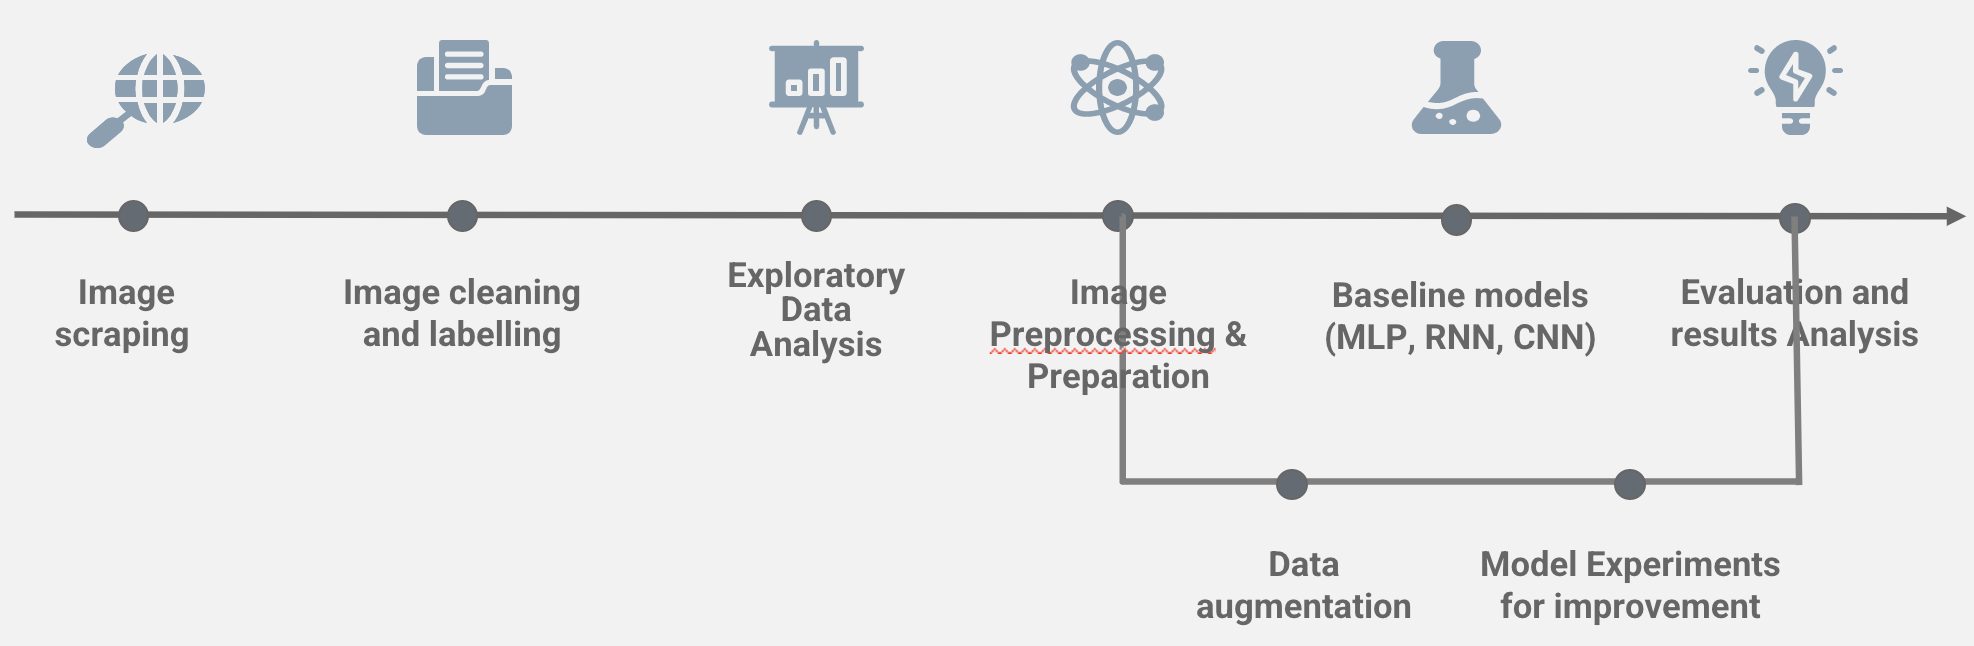

## 3.2 MLP (refer to MLP.ipynb)

### 3.2a) Model architecture

In [ ]:
# layers=[120, 84]
# more neurons: layers=[500,100]
# less neurons: layers=[100, 50]

class MLP(nn.Module):
  def __init__(self, input_size = size*size, output_size=10, layers=[120, 84]):
    super().__init__()
    self.h1 = nn.Linear(input_size, layers[0])
    
    self.h2 = nn.Linear(layers[0], layers[1])

    self.bn1 = nn.BatchNorm1d(num_features=84)
    self.out = nn.Linear(layers[1], output_size)

  def forward(self, X):
    X = F.relu(self.h1(X))
    X = F.relu(self.bn1(self.h2(X)))
    X = self.out(X)
    return F.log_softmax(X, dim=1)


In [ ]:
model = MLP()
print(model)

MLP(
  (h1): Linear(in_features=784, out_features=120, bias=True)
  (h2): Linear(in_features=120, out_features=84, bias=True)
  (bn1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 3.2b) MLP Iterative experiments and rationale

Detailed training/validation loss and accuracy graphs and numbers and explaination of results for each experiment can be found in **MLP.ipynb**

1. Experimenting with image resolution: 28x28 or 56x56. A higher resolution image used can result in less bias but higher variance which might cause testing accuracy to decrease. This is proven in the experiment results.

2. Increasing training sample size with data augmentation. Using data augmentation is the biggest contributer to the improved performance in MLP.

3. Increasing/Decreasing the learning rate. The original learning rate used is 0.001. Both increasing and decreasing it by a factor of 10 reduced the performance. An increased learning rate caused training loss to oscillate about the initial high value. This suggests that the gradient is not converging to optimal as the update step is too big. Decreasing the learning rate caused the gradient to converge too slowly and from the flat testing loss curve it shows that there is little learning done in the training.

4. More/less neurons. Originally, number of neurons used is 120 in the first layer and 84 in the second layer. These numbers are shown to be the best performing and the sweet spot and increasing or decreasing it cannot improve the model. Reducing number of nerons from 120 to 64 in layer1 and 84 to 64 in layer2 decreases the test accuracy. Although this network trains faster but it has too little capacity to learn the patterns in the training data. It is not complex enough and does not help with prediction. Increasing number of nerons from 120 to 500 in layer1 and 84 to 100 in layer2 also decreases the test accuracy. Additionally the training time per epoch also increases. From this we can see that, it is not necessary having more neurons can lead to better performance. In fact could lead to overfitting and hence poor performance on the validation set. 

5. Using 20% dropout before output layer. Introducing droupout reduces test accuracy. This could be because the number of nerons is already fewer and given the small datset and dropping out might decrease further the information learned from the images.

6. He initialisation. Based on other experiments and research, He initialisation works best for relu activation. 

7. Batch Normalisation before the output layer. Test accuracy increased by 22% (from 52% to 74%) after adding batch norm. Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. It is used close to the output layer to help with improving the performance and stability of the NN. 

8. Larger batch size. From the loss and accuracy curves we could tell that the values fluctuates quite a lot for each epoch. By increasing the batch size, we hope to smoothen the gradient update and improve the convergence. A larger batch size improved test accuracy by another 2% (from 74% to 76%).

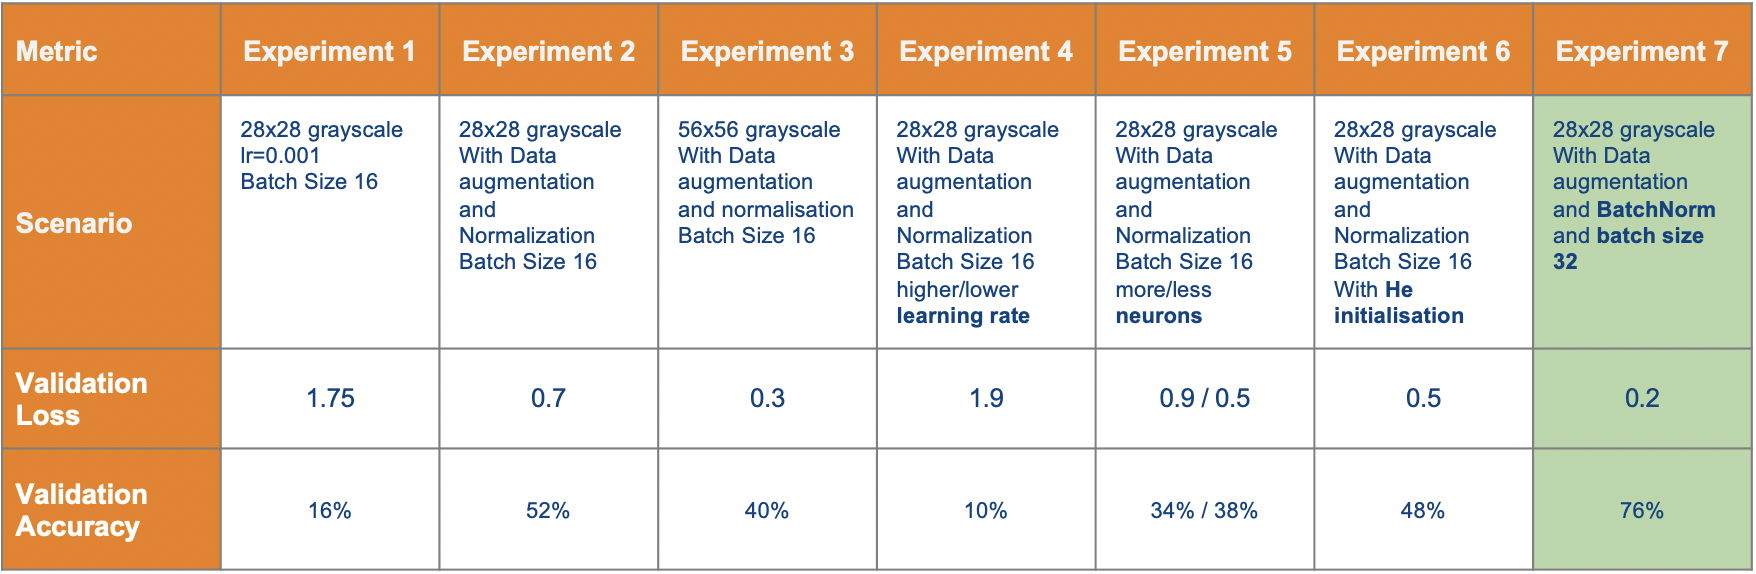



### 3.2c) Best model and model configuration

In [ ]:
torch.manual_seed(0)

train_batch_size = 32
test_batch_size = 50

train_data_size = 3360
test_data_size = 50

epochs = 40
train_losses =[]
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # run the training batches
  for b, (X_train, y_train) in enumerate(train_dataloaders):
    b+=1

    # apply the model
    y_pred = model(X_train.view(train_batch_size, -1)) # here we flatten X_train
    loss = criterion(y_pred, y_train)

    # calculate the number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1] # the prediction that has max probability
    batch_corr = (predicted==y_train).sum()
    trn_corr += batch_corr

    # update parameters
    optimizer.zero_grad() # reset the gradients after each training step
    loss.backward() # trigger backpropagation
    optimizer.step() # perfomr parameter update

  # print interim results
  print(f'epoch: {i:2} batch: {b:4} [{train_batch_size*b:6}/{train_data_size}] Train loss: {loss.item():10.8f} Train accuracy: {trn_corr.item()*100/train_data_size:.3f}%')

  # update train loss & accuracy for each epoch
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # run the testing batches
  with torch.no_grad(): # don't calculate gradients during testing
    for b, (X_test, y_test) in enumerate(test_dataloaders):

      # Apply the model
      y_val = model(X_test.view(test_batch_size, -1)) # Here we flatten X_test

      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  # update test loss & accuracy for the epoch
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

epoch:  0 batch:  105 [  3360/3360] Train loss: 1.57504666 Train accuracy: 41.310%
epoch:  1 batch:  105 [  3360/3360] Train loss: 1.41743731 Train accuracy: 53.125%
epoch:  2 batch:  105 [  3360/3360] Train loss: 1.42757702 Train accuracy: 59.315%
epoch:  3 batch:  105 [  3360/3360] Train loss: 1.23029113 Train accuracy: 64.881%
epoch:  4 batch:  105 [  3360/3360] Train loss: 1.04522610 Train accuracy: 68.244%
epoch:  5 batch:  105 [  3360/3360] Train loss: 0.89620733 Train accuracy: 71.488%
epoch:  6 batch:  105 [  3360/3360] Train loss: 0.82933903 Train accuracy: 72.887%
epoch:  7 batch:  105 [  3360/3360] Train loss: 0.76406574 Train accuracy: 76.012%
epoch:  8 batch:  105 [  3360/3360] Train loss: 0.63517714 Train accuracy: 79.048%
epoch:  9 batch:  105 [  3360/3360] Train loss: 0.45380765 Train accuracy: 80.089%
epoch: 10 batch:  105 [  3360/3360] Train loss: 0.55066228 Train accuracy: 82.173%
epoch: 11 batch:  105 [  3360/3360] Train loss: 0.44292808 Train accuracy: 81.607%
epoc

**Best Results from above model**

Initial model with 2 layer MLP, lr=0.001, training data 28x28 grayscale, 3360 samples, epochs = 40, Batch norm, batch_size=32

Test accuracy: 78.000%


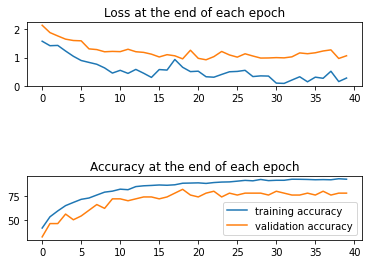

In [ ]:
# 28x28, lr=0.001
print(f'Test accuracy: {test_correct[-1].item()*100/test_data_size:.3f}%')

plt.subplot(3,1,1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(3,1,3)
plt.plot([t*100/train_data_size for t in train_correct], label="training accuracy")
plt.plot([t*100/test_data_size for t in test_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")

plt.legend()

#### Visualise test predictions

In [ ]:
predicted

tensor([5, 0, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 5, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 9, 6, 6, 6, 5, 4, 2, 7, 7, 7, 2, 9, 2, 8, 8, 5, 9, 9,
        9, 9])

In [ ]:
y_test

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9])

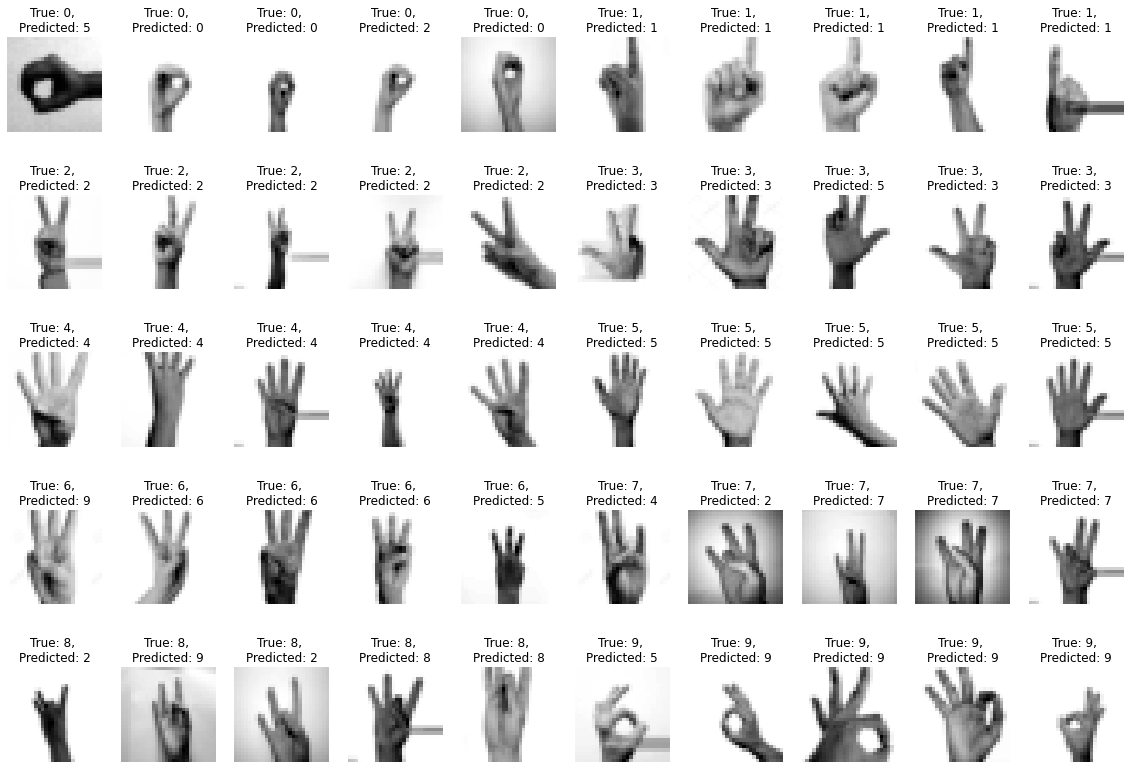

In [ ]:
# create figure
fig = plt.figure(figsize=(20, 14))
  
# setting values to rows and column variables
rows = 5
columns = 10
  
# reading images
Image = []
for i in range(50):
  image = image_datasets_test[i][0]
  Image.append(image)
  
# Adds a subplot at the 1st position
for i in range(50):
  fig.add_subplot(rows, columns, i+1)
    
  # showing image
  plt.imshow(Image[i].reshape((28,28)), cmap="gray")
  plt.axis('off')
  plt.title(f'True: {y_test[i].item()}, \nPredicted: {predicted[i].item()}' )
  



## 3.3 RNN (refer to RNN.ipynb)

### 3.3a) RNN model architecture

RNN is used to study the image pixel sequences.We treat each image as a sequence of 28 rows of 28 pixels.

In [ ]:
size = 28
BATCH_SIZE = 16
N_STEPS = 6
N_INPUTS = size
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 30

class ImageRNN(nn.Module):
    
    # declaraction of variables
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    # initialize hidden weights that have zero values
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
    
        out = self.FC(self.hidden)
        out = out.view(-1, self.n_outputs)
        return out # batch_size X n_output

In [ ]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model

ImageRNN(
  (basic_rnn): RNN(28, 150)
  (FC): Linear(in_features=150, out_features=10, bias=True)
)

### 3.3b) Iteration of Data: Training and Testing Model Maximal Accuracy

This is the code that puts together the model and its testing and training. The output gives the epoch, the loss function, and the percentage accuracy with every iteration. When it is ran, we see how the neural network gradually decreases the loss function, and has the accuracy approach 80% due to the optimization function and the adjustment of weights and biases. The 'Test Accuracy' portion at the bottom gives a final accuracy percentage after 30 epochs. And there you have it: image classification with recurrent neural networks!

In [ ]:
torch.manual_seed(0)

train_batch_size = 16
test_batch_size = 50

train_data_size = 3360
test_data_size = 50

epochs = 30
train_losses =[]
test_losses = []
train_correct = []
test_correct = []

predictions = []
target = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # run the training batches
  for b, (X_train, y_train) in enumerate(train_dataloaders):
    b+=1

    # apply the model
    X_train = X_train.view(-1, size,size)  # here we flatten X_train
    y_pred = model(X_train).to(device)
    if(y_pred.shape[0]==12):
          y_pred = y_pred.view(3,-1)
    else:
          y_pred = y_pred.view(train_batch_size,-1)
    loss = criterion(y_pred, y_train)

    # calculate the number of correct predictions
    predicted = torch.max(y_pred.data, 1)[1] # the prediction that has max probability
    batch_corr = (predicted==y_train).sum()
    trn_corr += batch_corr

    # update parameters
    optimizer.zero_grad() # reset the gradients after each training step
    loss.backward() # trigger backpropagation
    optimizer.step() # perfomr parameter update

  # print interim results
  print(f'epoch: {i:2} batch: {b:4} [{train_batch_size*b:6}/{train_data_size}] Train loss: {loss.item():10.8f} Train accuracy: {trn_corr.item()*100/train_data_size:.3f}%')

  # update train loss & accuracy for each epoch
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # run the testing batches
  with torch.no_grad(): # don't calculate gradients during testing
    for b, (X_test, y_test) in enumerate(test_dataloaders):
      # Apply the model
      X_test = X_test.view(-1, size,size) # Here we flatten X_test
      y_val = model(X_test).to(device)

      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      predictions.append(predicted)
      target.append(y_test)
      tst_corr += (predicted == y_test).sum()

  # update test loss & accuracy for the epoch
  loss = criterion(y_val, y_test)

  test_losses.append(loss)
  test_correct.append(tst_corr)

epoch:  0 batch:  210 [  3360/3360] Train loss: 1.73607087 Train accuracy: 26.012%
epoch:  1 batch:  210 [  3360/3360] Train loss: 1.85654342 Train accuracy: 27.381%
epoch:  2 batch:  210 [  3360/3360] Train loss: 2.02646375 Train accuracy: 29.732%
epoch:  3 batch:  210 [  3360/3360] Train loss: 1.87898040 Train accuracy: 31.518%
epoch:  4 batch:  210 [  3360/3360] Train loss: 1.97610462 Train accuracy: 31.310%
epoch:  5 batch:  210 [  3360/3360] Train loss: 2.08277583 Train accuracy: 32.232%
epoch:  6 batch:  210 [  3360/3360] Train loss: 1.62025452 Train accuracy: 28.065%
epoch:  7 batch:  210 [  3360/3360] Train loss: 1.86753654 Train accuracy: 31.429%
epoch:  8 batch:  210 [  3360/3360] Train loss: 1.99724686 Train accuracy: 34.345%
epoch:  9 batch:  210 [  3360/3360] Train loss: 1.62846804 Train accuracy: 35.179%
epoch: 10 batch:  210 [  3360/3360] Train loss: 2.18777776 Train accuracy: 40.060%
epoch: 11 batch:  210 [  3360/3360] Train loss: 1.58142602 Train accuracy: 40.357%
epoc

For image 28x28 we observed that without augmentation, accuracy is around 22%. It increased when we augmented the data size to 3360 and normalized it. It remained good when we doubled the batch size to 32. But decreased with changing the neurons. ​

Increasing the pixel image size decreased the accuracy, which could be due to higher variance. ​

### 3.3c) **Best Model is with 28x28 grayscale, lr=0.001, numSteps = 6 , Epochs = 30, With Data Augmentation train set = 3360 , test set = 50**

Test accuracy: 72.000%


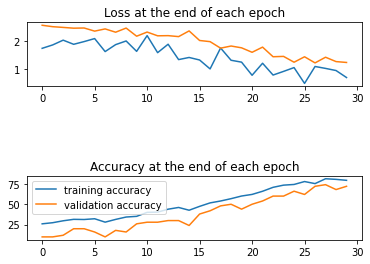

In [ ]:
print(f'Test accuracy: {test_correct[-1].item()*100/test_data_size:.3f}%')

plt.subplot(3,1,1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(3,1,3)
plt.plot([t*100/train_data_size for t in train_correct], label="training accuracy")
plt.plot([t*100/test_data_size for t in test_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")

plt.legend()

**Inferences on the experiments**

Detailed training/validation loss and accuracy graphs and numbers and explaination of results for each experiment can be found in **RNN.ipynb**

1. Experimenting with image resolution: 28x28 or 56x56. A higher resolution image used can result in less bias but higher variance which might cause testing accuracy to decrease. This is proven in the experiment results.

2. Increasing training sample size with data augmentation. Using data augmentation is the biggest contributer to the improved performance in RNN.

3. Upon increasing the number of timeSteps to 28, the model accuracy dropped. Noise would have amplified when the timeSteps are higher. 


**RNN Model is able to predict 36/50 images correctly. It can predict 5 and 9 most accurately because we have more training data for these two digits.**

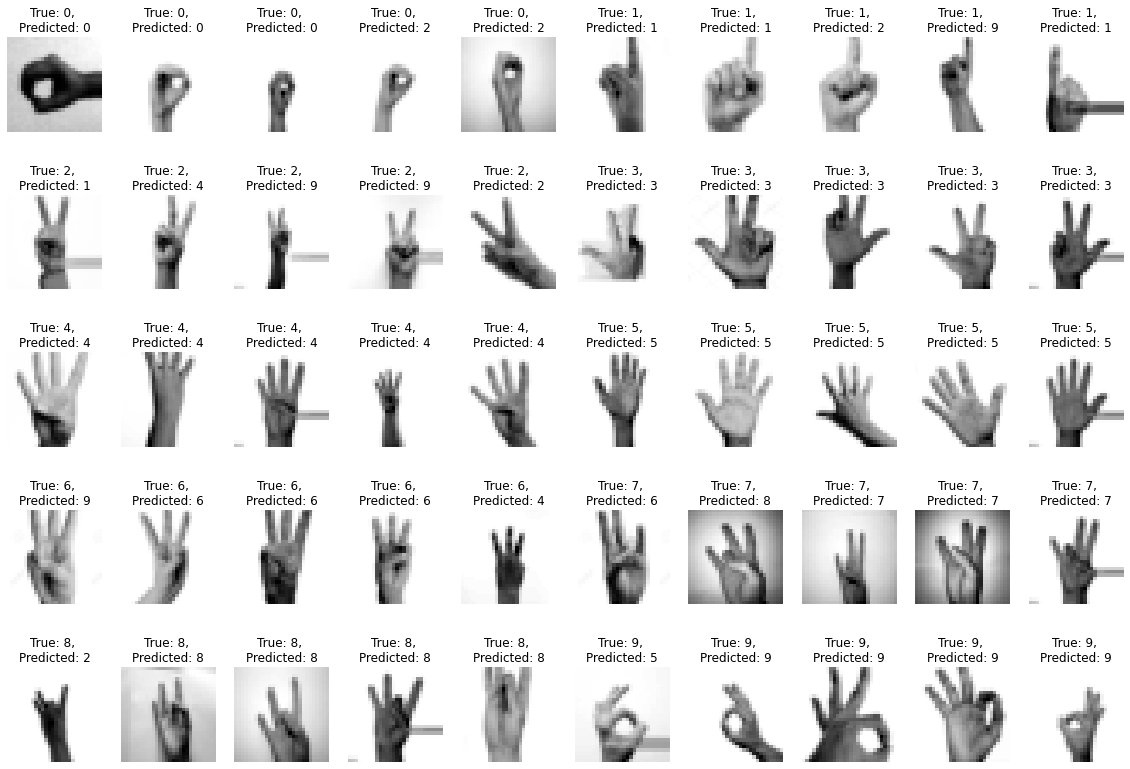

In [ ]:
# create figure
fig = plt.figure(figsize=(20, 14))
  
# setting values to rows and column variables
rows = 5
columns = 10
  
# reading images
Image = []
for i in range(50):
  image = image_datasets_test[i][0]
  Image.append(image)
  
# Adds a subplot at the 1st position
for i in range(50):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(Image[i].reshape((28,28)), cmap="gray")
    plt.axis('off')
    plt.title(f'True: {target[epochs -1][i]}, \nPredicted: {predictions[epochs -1][i]}' )
  



## 3.4 Modelling and Experimentation - CNN

4 Experiments with different CNN architectures were performed. They have been addressed as follows throughout the section and in presentation.

- 3.4.a. Baseline CNN Model
- 3.4.b. CNN Model with Augmented Data
- 3.4.c. AlexNet CNN Architecture
- 3.4.d. AlexNet CNN Architecture with Augmented Data
- 3.4.e. Best CNN Model configurations


### 3.4a) Baseline CNN Model

Convolutional Neural Networks are capable of interpreting spatial relationships between nearby pixels because CNN assumes that pixels that are closer are more correlated, which is valid in a lot of real-life images when analysed. CNN also accounts for image stationarity as an assumption, because it applies same filter to different parts. Thus for detailed pixel photos, CNN is expected to perform better than MLP. The scraped dataset was preprocessed through the basic image transformations with a resize of 112x112 for higher resolution. Convolution 2D layers were ReLU activated with a combination of maxpool 2D and dropout layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(24*24*32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(model)

it = iter(train_dataloader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([16, 10])


### Load American Sign Language Dataset for Baseline CNN

Web scraped images for digits from 3 sources namely, Google, Istockphoto and Gettyimages were cleaned and labelled. The cleaned dataset consists of 722 total images. These were split into training (672) and test (50) images. The distribution of images for each label is imbalanced. For best performing model AlexNet architecture of CNNs. all training and test images were resized to 224x224 and all 3input channels. Normalisation helps in standardising the images further.

For baseline CNN model, all training and test images were resized to 112x112 and only 1 input channel. Normalisation helps in standardising the images further.**

In [ ]:
size = 112
train_data_transforms_original = transforms.Compose([transforms.Resize(size),
                                                    transforms.CenterCrop(size),
                                                    transforms.Grayscale(),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.485), (0.224))
                                                    ]) 
val_data_transforms = transforms.Compose([transforms.Resize(size),
                                        transforms.CenterCrop(size),
                                        transforms.Grayscale(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485), (0.224))
                                        ])

In [ ]:
image_datasets_train = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_original)
image_datasets_test = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/test_human/", transform=val_data_transforms)


In [ ]:
# Step 2: Using the image datasets and the transforms, define the dataloaders

train_data_size = len(image_datasets_train)
test_data_size = len(image_datasets_test)
train_batch_size = 16
test_batch_size = 50
train_dataloader = DataLoader(image_datasets_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(image_datasets_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [ ]:
print("train dataset before augmentation: ", len(image_datasets_train))
print("Total number of Train batches: ", len(train_dataloader))

train dataset before augmentation:  672
Total number of Train batches:  42


In [ ]:
print("test dataset size: ", len(image_datasets_test))
print("Total number of test batches: ", len(test_dataloader))

test dataset size:  50
Total number of test batches:  1


#### Visualise single train image from train_dataloader first batch first image

img.shape: torch.Size([16, 1, 112, 112]) | #images: 16 | Each image shape: torch.Size([1, 112, 112]) | label.shape: torch.Size([16])
First Ground Truth Label: 5
image.permute(1,2,0): torch.Size([112, 112, 1])


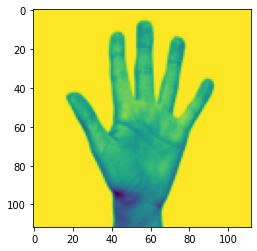

In [ ]:
for img, label in train_dataloader:
    # dim of img = (train_batch_size, number of RGB channels, image_size, image_size))
    image = img[0] # Get first image from train_loader first batch
    print(f"img.shape: {img.shape} | #images: {img.shape[0]} | Each image shape: {img.shape[1:]} | label.shape: {label.shape}")
    print(f'First Ground Truth Label: {label[0]}')
    plt.imshow(img[0][0]) # No need to permute
    break

#### Visualise single test image from test_dataloader first batch first image

img.shape: torch.Size([50, 1, 112, 112]) | #images: 50 | Each image shape: torch.Size([1, 112, 112]) | label.shape: torch.Size([50])
First Ground Truth Label: 0
image.permute(1,2,0): torch.Size([112, 112, 1])


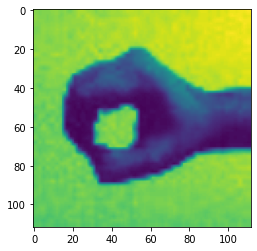

In [ ]:
for img, label in test_dataloader:
    # dim of img = (test_batch_size, number of RGB channels, image_size, image_size))
    print(f"img.shape: {img.shape} | #images: {img.shape[0]} | Each image shape: {img.shape[1:]} | label.shape: {label.shape}")
    print(f'First Ground Truth Label: {label[0]}')
    print(f"image.permute(1,2,0): {image.permute(1,2,0).shape}") # Not needed for single channel Grayscaled image
    plt.imshow(img[0][0]) # No need to permute
    # break

### Training Baseline CNN model with following hyperparameters:
 - train_batch_size = 16
 - learning_rate = 0.0001
 - epochs = 50

In [ ]:
torch.manual_seed(0)

epochs = 50

train_losses =[]
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    model.train()

    trn_corr = 0
    tst_corr = 0
    running_loss = 0.0
    print(f"Starting epoch {i+1}")

    # run the training batches
    for b, data in enumerate(train_dataloader):

        X_train, y_train = data[0].to(device), data[1].to(device)
        
        # reset the gradients after each training step
        optimizer.zero_grad() 

        # apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # update parameters
        loss.backward() # trigger backpropagation
        optimizer.step() # perfome parameter update

        # calculate the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1] # the prediction that has max probability
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr
        running_loss += loss.item()
    
    # update train loss & accuracy for each epoch
    train_losses.append(running_loss)
    train_correct.append(trn_corr)

    # run the testing batches
    with torch.no_grad(): # don't calculate gradients during testing
        test_running_loss = 0.0
        for b, (X_test, y_test) in enumerate(test_dataloader):

            # Apply the model
            y_val = model(X_test) # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            # update test loss & accuracy for the epoch
            loss = criterion(y_val, y_test)
            test_running_loss += loss.item()
    
    test_losses.append(test_running_loss)
    test_correct.append(tst_corr)

    print(f'After epoch: {i+1} \t Train loss: {running_loss:10.4f} \t Train accuracy: {(trn_corr.item()*100)/train_data_size:.3f}%')
    print(f'\t \t Test loss: {test_losses[-1]:10.4f} \t \t Test accuracy: {(test_correct[-1].item()*100)/test_data_size:.3f}%\n')

Starting epoch 1
After epoch: 1 	 Train loss:    90.5789 	 Train accuracy: 23.661%
Again epoch: 1 	 Train loss:    90.5789 	 Train accuracy: 23.661%
	 	 Test loss:     2.5995 	 	 Test accuracy: 8.000%

Starting epoch 2
After epoch: 2 	 Train loss:    85.3007 	 Train accuracy: 23.958%
Again epoch: 2 	 Train loss:    85.3007 	 Train accuracy: 23.958%
	 	 Test loss:     2.5347 	 	 Test accuracy: 6.000%

Starting epoch 3
After epoch: 3 	 Train loss:    85.2777 	 Train accuracy: 23.810%
Again epoch: 3 	 Train loss:    85.2777 	 Train accuracy: 23.810%
	 	 Test loss:     2.6039 	 	 Test accuracy: 16.000%

Starting epoch 4
After epoch: 4 	 Train loss:    85.0403 	 Train accuracy: 22.321%
Again epoch: 4 	 Train loss:    85.0403 	 Train accuracy: 22.321%
	 	 Test loss:     2.6068 	 	 Test accuracy: 10.000%

Starting epoch 5
After epoch: 5 	 Train loss:    85.7254 	 Train accuracy: 21.875%
Again epoch: 5 	 Train loss:    85.7254 	 Train accuracy: 21.875%
	 	 Test loss:     2.6584 	 	 Test accura

In [ ]:
train_correct[-1].item()

649

### Evaluating performance of Baseline CNN

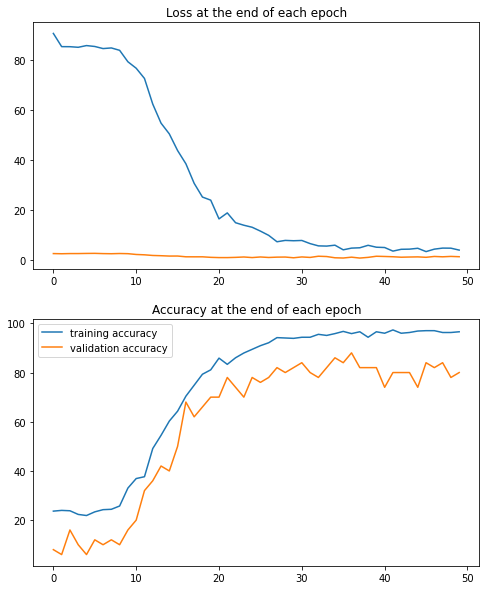

In [ ]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot([loss for loss in train_losses], label='training loss')
plt.plot([loss for loss in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(2, 1, 2)
plt.plot([t*100/train_data_size for t in train_correct], label="training accuracy")
plt.plot([t*100/test_data_size for t in test_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")

plt.legend()

In [ ]:
test_correct = 0
total = 0

# run the testing batches
with torch.no_grad(): # don't calculate gradients during testing
    for b, data in enumerate(test_dataloader):
        X_test, y_test = data[0].to(device), data[1].to(device)
        # Apply the model
        y_val = model(X_test) # Here we flatten X_test

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        total += y_test.size(0)
        test_correct += (predicted == y_test).sum().item()

print(f'Accuracy of the network on test images: {100 * test_correct // total} %')

Accuracy of the network on test images: 82 %


**Results and Evaluation**

Baseline CNN Model Training starts to converge after 30 epochs. Training for more epochs improves performance. The model learns parameters until 30 epochs after which the training seems to have converged since the Validation Accuracy toggles between range 78 - 84%, occasionally peaking at 88%. Test accuracy for baseline cnn model was recorded to be 82%.

### 3.4b) CNN Model with Augmented Data

Baseline CNN Architecture was trained with augmented dataset. A total of 672 * 5 = 3360 images were obtained for training models with augmented data.

Epoch vs Validation Loss and Validation Accuracy:

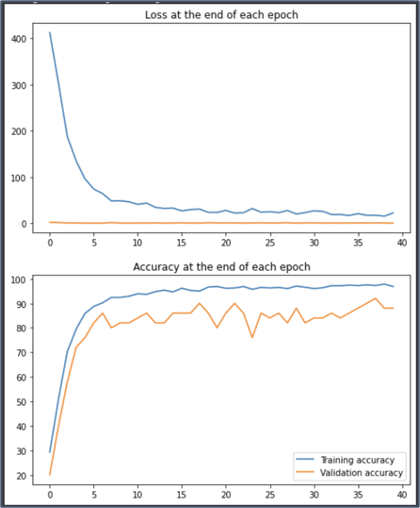

#### Prediction vs True Labels from CNN Model with Augmented Data:

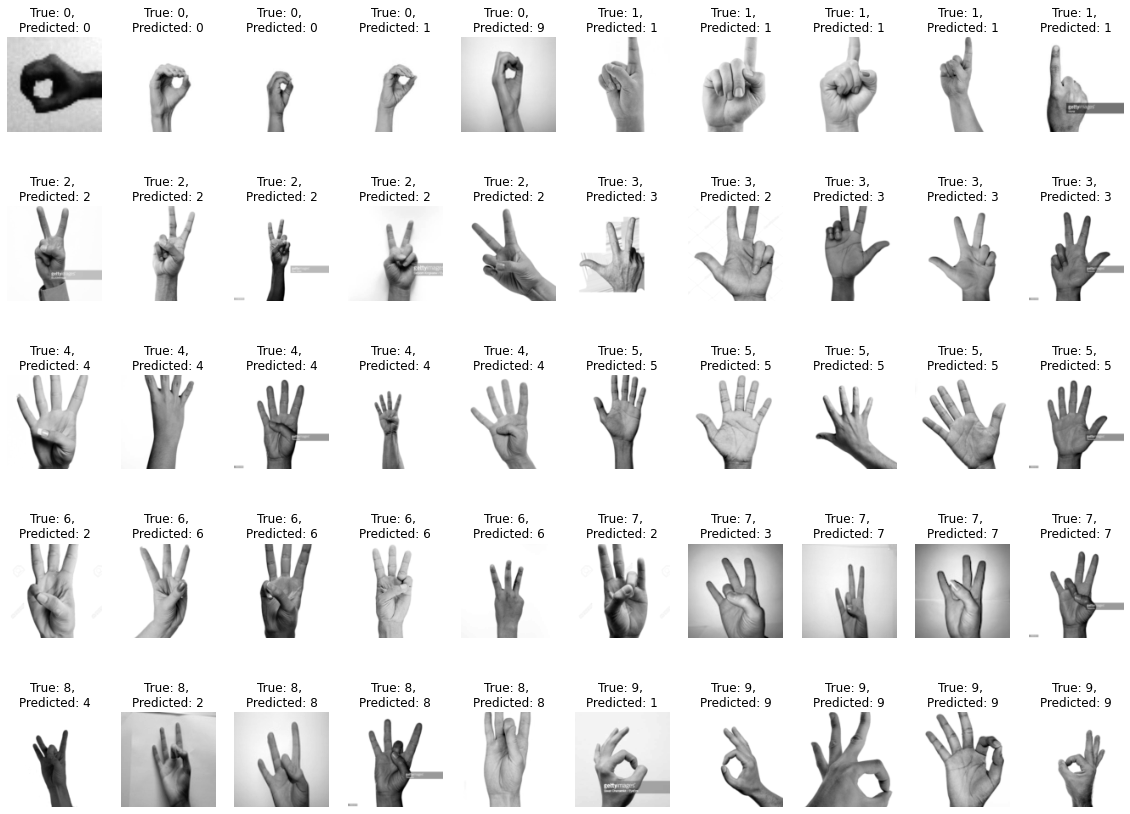

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/NNDL_Group_project/Working folder/CNN_augmented_data_graphs.png', width=800, height=10000) 
Image(filename='/content/drive/MyDrive/NNDL_Group_project/Working folder/CNN_augmented_data_output.png', width=2000, height=1500) 

**Results and Evaluation**

The data was augmented using Gaussian noise, horizontal flip and more transformations mentioned in image preparation stage. 5 times the size of original data was fed to same architecture of CNN model. We can infer that more data helps CNN model training to converge faster within 10 epoch and record an accuacy of 88% after which the validation accuracy toggles between 86 – 92%. **Test accuracy of CNN model with same architecture and augmented data was recorded to be 88%**

### 3.3c) AlexNet CNN Architecture - Reference CNN AlexNet GPU.ipynb

AlexNet architecture published in Krizhevsky A. et.al[10] was adopted to train the augmented images dataset. AlexNet has 8 layerscomprising of 5 convolutional and 3 fully connected. At the point of publication, the authors pointed out that their architecture was “one of the largest convolutional neural networks to date on the subsets of ImageNet.” In 2012, the uniqueness of this architecture came from the fact that they were the first to ReLU activation functions and use Dropout layers with maxpool CNN layers for regularisation.

AlexNet had 60 million parameters, which might introduce overfitting. Dropout technique consists of “turning off” neurons with a predetermined probability (e.g. 50%). This means that every iteration uses a different sample of the model’s parameters, which forces each neuron to have more robust features that can be used with other random neurons. However, dropout also increases the training time needed for the model’s convergence.

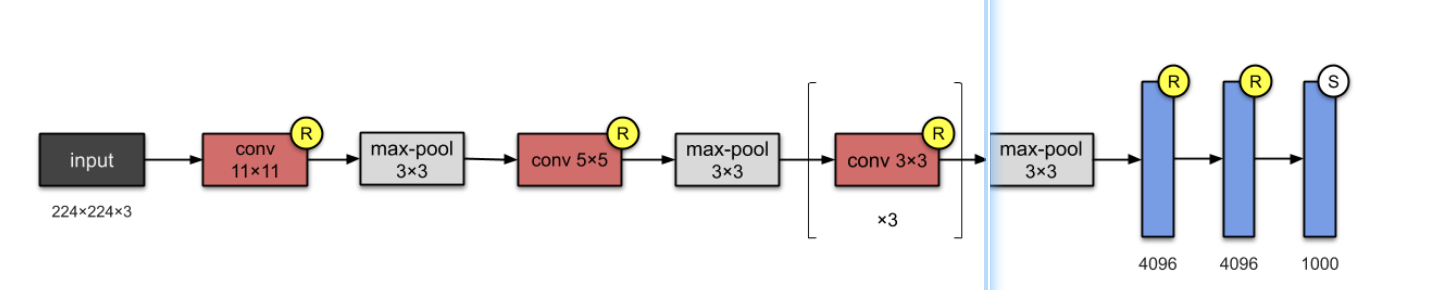

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/NNDL_Group_project/Working folder/AlexNet architecture.png', width=850, height=200) 

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


    def training_step(self, batch):
        """ Returns loss for a training data"""
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        """Finding loss and accuracy for a batch of validation data"""
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss, 'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss':epoch_loss,'val_acc':epoch_accuracy}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:5.4f}, val_acc: {:5.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
num_classes = 10
model = AlexNet(num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Creating a helper function to switch between CPU and GPU
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Defining a function to move data/model to the GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Creating the class Devicedataloader
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        #By calling yield, each time a batch is returned to the device from the dataloader.
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

def fit(epochs, lr, model,train_dataloader, val_dataloader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation phase
        result = evaluate(model,val_dataloader)
        model.epoch_end(epoch,result)# Result after each epoch
        history.append(result)
    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#### Load American Sign Language Dataset for AlexNet
**For AlexNet architecture of CNNs, all training and test images were resized to 224x224 and all 3 input channels. Normalisation was performed on all 3 dimesnsions of the image for standardisation.**

In [ ]:
train_data_transforms_original = transforms.Compose([transforms.Resize(224),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                    ])

val_data_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                        ])

In [ ]:
image_datasets_train = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_original)
image_datasets_test = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/test_human/", transform=val_data_transforms)


In [ ]:
# Step 2: Using the image datasets and the transforms, define the dataloaders
torch.manual_seed(0)

train_data_size = len(image_datasets_train)
test_data_size = len(image_datasets_test)
train_batch_size = 16
test_batch_size = 50
train_dataloader = DataLoader(image_datasets_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(image_datasets_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [ ]:
print("train dataset before augmentation: ", len(image_datasets_train))
print("Total number of Train batches: ", len(train_dataloader))

train dataset before augmentation:  672
Total number of Train batches:  42


In [ ]:
print("test dataset size: ", len(image_datasets_test))
print("Total number of test batches: ", len(test_dataloader))

test dataset size:  50
Total number of test batches:  1


img.shape: torch.Size([16, 3, 224, 224]) | #images: 16 | Each image shape: torch.Size([3, 224, 224]) | label.shape: torch.Size([16])
First Ground Truth Label: 5


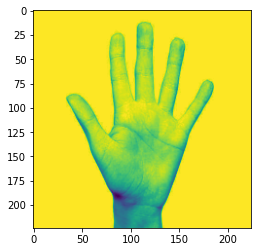

In [ ]:
for img, label in train_dataloader:
    # dim of img = (train_batch_size, number of RGB channels, image_size, image_size))
    image = img[0] # Get first image from train_loader first batch
    print(f"img.shape: {img.shape} | #images: {img.shape[0]} | Each image shape: {img.shape[1:]} | label.shape: {label.shape}")
    print(f'First Ground Truth Label: {label[0]}')
    plt.imshow(img[0][0]) # No need to permute
    break

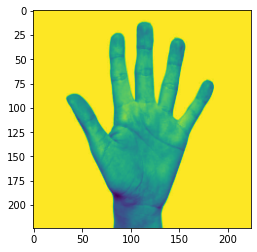

In [ ]:
# for multiple channels only
plt.imshow(image[1])

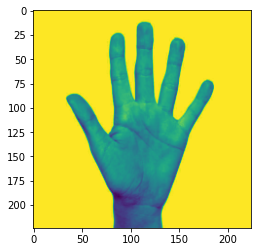

In [ ]:
plt.imshow(image[2])

img.shape: torch.Size([50, 3, 224, 224]) | #images: 50 | Each image shape: torch.Size([3, 224, 224]) | label.shape: torch.Size([50])
First Ground Truth Label: 0


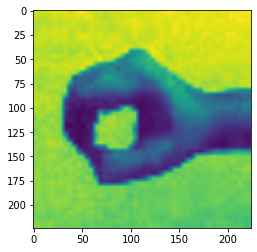

In [ ]:
for img, label in test_dataloader:
    # dim of img = (test_batch_size, number of RGB channels, image_size, image_size))
    print(f"img.shape: {img.shape} | #images: {img.shape[0]} | Each image shape: {img.shape[1:]} | label.shape: {label.shape}")
    print(f'First Ground Truth Label: {label[0]}')
    plt.imshow(img[0][0]) # No need to permute
    # break

#### Training AlexNet Architecture using GPU for 40 epochs to observe performance
- train_batch_size = 16
- learning_rate = 0.0001
- epochs = 40

In [ ]:
device = get_default_device()
# set our train_data and test_data on GPU
train_dataloader = DeviceDataLoader(train_dataloader,device)
val_dataloader = DeviceDataLoader(test_dataloader, device)
# set model onto GPU
to_device(model, device)
# Calculaitng the performance of the model with inital parameters withhout training.
history = [evaluate(model, val_dataloader)]
print(history)

In [ ]:
# Training for 40 epochs with lr=0.0001 to see performance. 
# Recording  validation loss and Validation accuracy
history+= fit(40, 0.0001, model, train_dataloader, val_dataloader)

Epoch [1], val_loss: 2.5148, val_acc: 0.1000
Epoch [2], val_loss: 2.4478, val_acc: 0.1000
Epoch [3], val_loss: 2.6739, val_acc: 0.1400
Epoch [4], val_loss: 2.5226, val_acc: 0.2600
Epoch [5], val_loss: 2.4757, val_acc: 0.3000
Epoch [6], val_loss: 1.7807, val_acc: 0.3400
Epoch [7], val_loss: 1.6806, val_acc: 0.4200
Epoch [8], val_loss: 1.2488, val_acc: 0.5800
Epoch [9], val_loss: 1.2446, val_acc: 0.5600
Epoch [10], val_loss: 1.2477, val_acc: 0.5000
Epoch [11], val_loss: 0.8966, val_acc: 0.6600
Epoch [12], val_loss: 0.7319, val_acc: 0.7600
Epoch [13], val_loss: 0.5647, val_acc: 0.8200
Epoch [14], val_loss: 0.8165, val_acc: 0.7000
Epoch [15], val_loss: 0.4622, val_acc: 0.9000
Epoch [16], val_loss: 0.5615, val_acc: 0.8400
Epoch [17], val_loss: 0.6983, val_acc: 0.7400
Epoch [18], val_loss: 0.6678, val_acc: 0.9200
Epoch [19], val_loss: 0.3796, val_acc: 0.9000
Epoch [20], val_loss: 0.4712, val_acc: 0.9000
Epoch [21], val_loss: 0.3749, val_acc: 0.8800
Epoch [22], val_loss: 0.3081, val_acc: 0.90

#### Evaluation AlexNet Architecture

Plot Validation Loss and Validation Accuracy vs Epochs to study the training pattern

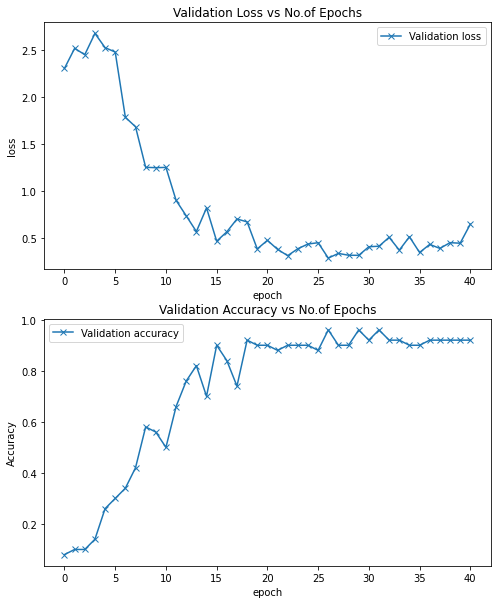

In [ ]:
losses = [x['val_loss'].cpu().data.numpy() for x in history]
accuracy = [x['val_acc'].cpu().data.numpy() for x in history]

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(losses, '-x', label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No.of Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(accuracy, '-x', label="Validation accuracy")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy vs No.of Epochs")
plt.legend()

In [ ]:
num_classes = 10

def evaluate_classes(dataloader, num_classes, model, loss_fn):

    test_correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for data in dataloader:
            images, y_true = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == y_true).squeeze()
            total += y_true.size(0)
            test_correct += (predicted == y_true).sum().item()
            for i in range(len(y_true)):
                label = y_true[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(num_classes):
        print(f'Label: {i} | Accuracy: {(100 * class_correct[i] / class_total[i])}%')
    print(f'Accuracy of the network on all test images: {100 * test_correct/total} %')
    return predicted, c
    
predicted, c = evaluate_classes(val_dataloader, num_classes, model, nn.CrossEntropyLoss())

Label: 0 | Accuracy: 100.0%
Label: 1 | Accuracy: 100.0%
Label: 2 | Accuracy: 80.0%
Label: 3 | Accuracy: 100.0%
Label: 4 | Accuracy: 100.0%
Label: 5 | Accuracy: 100.0%
Label: 6 | Accuracy: 100.0%
Label: 7 | Accuracy: 60.0%
Label: 8 | Accuracy: 80.0%
Label: 9 | Accuracy: 100.0%
Accuracy of the network on all test images: 92.0 %


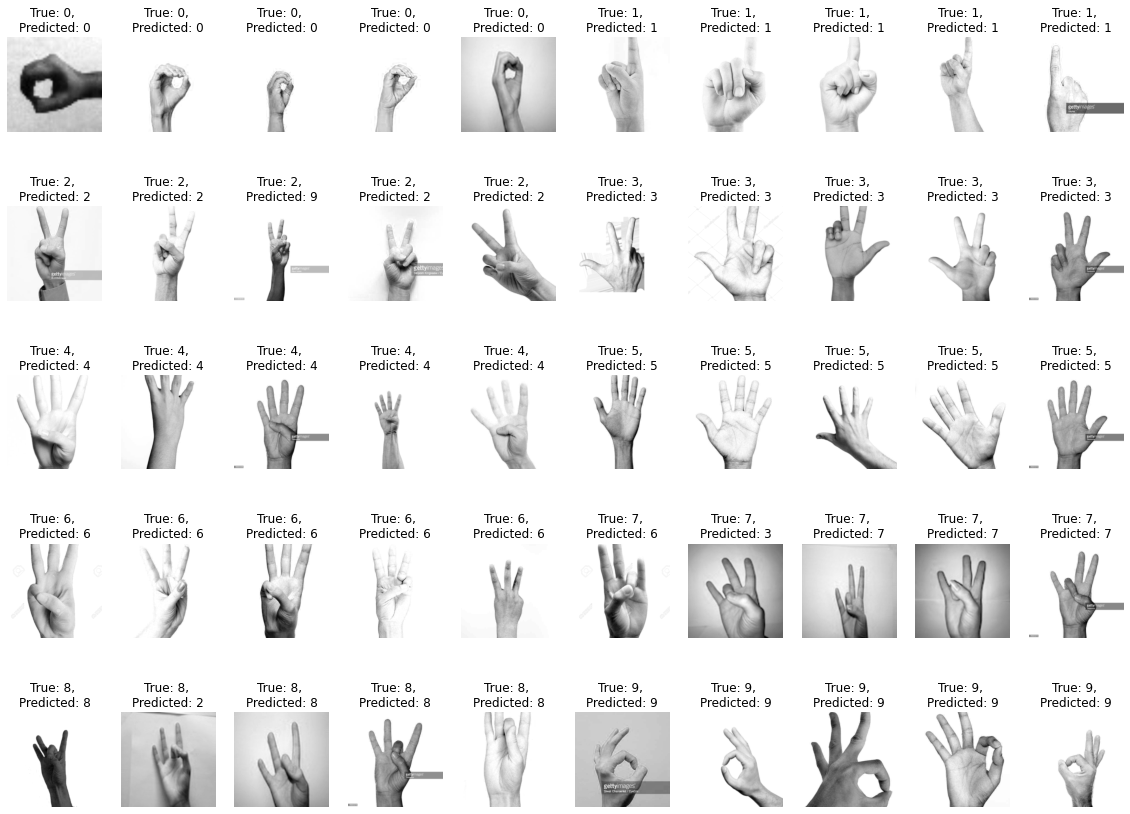

In [ ]:
# create figure
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 5
columns = 10
  
# reading images
Image = []
for i in range(test_data_size):
    image = image_datasets_test[i][0]
    Image.append(image)

for data in val_dataloader:
    images, true_labels = data
    break

  
# Adds a subplot at the 1st position
for i in range(50):
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(Image[i][0], cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_labels[i].item()}, \nPredicted: {predicted[i].item()}')

### 3.3d) AlexNet CNN Architecture with Augmented data - Reference CNN AlexNet with Augmented Data GPU.ipynb

### Data Augmentation

Data Augmentation is a technique to create synthetic datasamples using the current dataset, by making minor transformations that do not tamper with the identify of the subject. Deep Neural Networks require more samples for training, where data augmentation plays an important role to increase the dataset size. Advantages of using data augmentation are:
- Allows models to generalize better by adding diveristy 
- Prevent overfitting of models with high number of model parameters
- ML models can be made more robust by adding variances that the model can encounter while making real-world predictions. 

Only the training dataset was augmented with the following transformations:
- Horizontal Flip
- Original with Gaussian Noise
- Flipped with Gaussian Noise
- Original with random erasing

A total of 672 * 5 = 3360 images were obtained for training models with augmented data.


In [ ]:
# Step 0: Define basic/original image transformation for training data
size = 224
train_data_transforms_original = transforms.Compose([transforms.Resize(size),
                                                    transforms.CenterCrop(size),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                    ])
# Horizontally flip standardised images
train_data_transforms_with_horizontal_flip = transforms.Compose([transforms.Resize(size),
                                                                transforms.CenterCrop(size),
                                                                transforms.RandomHorizontalFlip(),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                                ])

# Add Gussian Noise to basic transfrmed image
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_data_transforms_with_gaussian_noise_orginal = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                                  AddGaussianNoise(0.1, 0.08),])

# Add Gussian Noise to randomly horizontally flipped transfrmed image
train_data_transforms_with_gaussian_noise_flipped = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.RandomHorizontalFlip(),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                                  AddGaussianNoise(0.1, 0.08),])

# Randomly erase some parts of the image, so that model is also capable of detecting signs not very accurate
train_data_transforms_with_random_erasing = transforms.Compose([transforms.Resize(size),
                                                                  transforms.CenterCrop(size),
                                                                  transforms.ToTensor(),
                                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                                  transforms.RandomErasing(),])

# Basic image transformations only on validation dataset
val_data_transforms = transforms.Compose([transforms.Resize(size),
                                        transforms.CenterCrop(size),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                        ])


In [ ]:
# Step 1 : Load the datasets with ImageFolder
train_data = []
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_original))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_horizontal_flip))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_gaussian_noise_orginal))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_gaussian_noise_flipped))
train_data.append(datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/train_final/", transform=train_data_transforms_with_random_erasing))

image_datasets_train = torch.utils.data.ConcatDataset(train_data)
image_datasets_test = datasets.ImageFolder(root= "/content/drive/MyDrive/NNDL_Group_project/data/cleaned_dataset_digits/test_human/", transform=val_data_transforms)


In [ ]:
# Step 2: Using the image datasets and the transforms, define the dataloaders
train_data_size = len(image_datasets_train)
test_data_size = len(image_datasets_test)

train_batch_size = 16
test_batch_size = 50

train_dataloader = DataLoader(image_datasets_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(image_datasets_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [ ]:
# Step 3: Display training and test dataloaders statistics
print("Train dataset after augmentation: ", len(image_datasets_train))
print("Total number of Train batches: ", len(train_dataloader))
print("Test dataset size: ", len(image_datasets_test))
print("Total number of test batches: ", len(test_dataloader))

train dataset before augmentation:  3360
Total number of Train batches:  210


Shape:  torch.Size([3, 224, 224]) 
label:  0


Text(0.5, 1.0, 'Original')

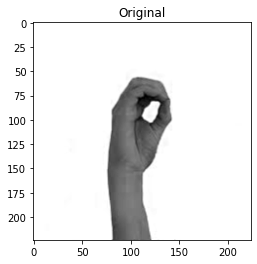

In [ ]:
# Step 4: Display one sample of augmeneted images
image, label = image_datasets_train[0]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image[0].reshape((size, size)), cmap="gray")
plt.title(f'Original')

Shape:  torch.Size([3, 224, 224]) 
label:  0


Text(0.5, 1.0, 'horizontal_flip')

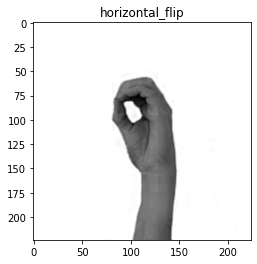

In [ ]:
image, label = image_datasets_train[672]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image[0].reshape((size, size)), cmap="gray")
plt.title(f'horizontal_flip')

Shape:  torch.Size([3, 224, 224]) 
label:  0


Text(0.5, 1.0, 'gaussian_noise_orginal')

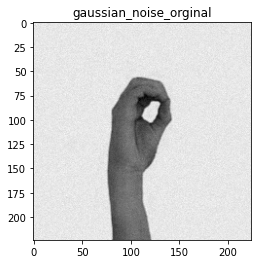

In [ ]:
image, label = image_datasets_train[1344]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image[0].reshape((size, size)), cmap="gray")
plt.title(f'gaussian_noise_orginal')

Shape:  torch.Size([3, 224, 224]) 
label:  0


Text(0.5, 1.0, 'gaussian_noise_flipped')

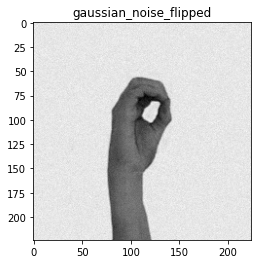

In [ ]:
image, label = image_datasets_train[2016]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image[0].reshape((size, size)), cmap="gray")
plt.title(f'gaussian_noise_flipped')

Shape:  torch.Size([3, 224, 224]) 
label:  0


Text(0.5, 1.0, 'random_erasing')

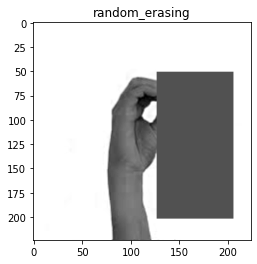

In [ ]:
image, label = image_datasets_train[2688]
print('Shape: ', image.shape, '\nlabel: ', label)
plt.imshow(image[0].reshape((size, size)), cmap="gray")
plt.title(f'random_erasing')

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


    # Functions to facilitate training, validating and evaluating on GPU
    def training_step(self, batch):
        """ Returns loss for a training data"""
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        """Finding loss and accuracy for a batch of validation data"""
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss, 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss':epoch_loss,'val_acc':epoch_accuracy}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
num_classes = 10
model = AlexNet(num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Check forward function execution for one iteration
it = iter(train_dataloader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

torch.Size([16, 10])


In [ ]:
# Creating a helper function to switch between CPU and GPU
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Defining a function to move data/model to the GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Creating the class Devicedataloader
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        #By calling yield, each time a batch is returned to the device from the dataloader.
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

def fit(epochs, lr, model,train_dataloader, val_dataloader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training phase
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation phase
        result = evaluate(model,val_dataloader)
        model.epoch_end(epoch,result)# Result after each epoch
        history.append(result)
    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

device = get_default_device()

# set our train_data and test_data on GPU
train_dataloader = DeviceDataLoader(train_dataloader,device)
val_dataloader = DeviceDataLoader(test_dataloader, device)

# set model onto GPU
to_device(model, device)

# Calculaitng the performance of the model with inital parameters withhout training.
history = [evaluate(model, val_dataloader)]
print(history)

[{'val_loss': tensor(2.3031, device='cuda:0', grad_fn=<MeanBackward0>), 'val_acc': tensor(0.1000)}]


#### Training CNN AlexNet with Augmented Data on GPU

In [ ]:
# Training for 40 epochs with lr=0.0001 to see performance. 
# Recording  validation loss and Validation accuracy
history+= fit(40, 0.0001, model, train_dataloader, val_dataloader)

Epoch [1], val_loss: 2.5273, val_acc: 0.1200
Epoch [2], val_loss: 1.5811, val_acc: 0.4800
Epoch [3], val_loss: 1.2835, val_acc: 0.5400
Epoch [4], val_loss: 0.6216, val_acc: 0.8200
Epoch [5], val_loss: 0.8243, val_acc: 0.7800
Epoch [6], val_loss: 0.3404, val_acc: 0.9200
Epoch [7], val_loss: 0.4447, val_acc: 0.8800
Epoch [8], val_loss: 0.4647, val_acc: 0.9200
Epoch [9], val_loss: 0.2190, val_acc: 0.9400
Epoch [10], val_loss: 0.4335, val_acc: 0.9000
Epoch [11], val_loss: 0.2890, val_acc: 0.9000
Epoch [12], val_loss: 0.1848, val_acc: 0.9800
Epoch [13], val_loss: 0.3112, val_acc: 0.9400
Epoch [14], val_loss: 0.3867, val_acc: 0.9200
Epoch [15], val_loss: 0.5105, val_acc: 0.8800
Epoch [16], val_loss: 0.2553, val_acc: 0.9400
Epoch [17], val_loss: 0.2022, val_acc: 0.9200
Epoch [18], val_loss: 0.2976, val_acc: 0.9200
Epoch [19], val_loss: 0.1382, val_acc: 0.9600
Epoch [20], val_loss: 0.2486, val_acc: 0.9400
Epoch [21], val_loss: 0.4715, val_acc: 0.9600
Epoch [22], val_loss: 0.4098, val_acc: 0.94

In [ ]:
# Training existing model for 10 more epochs with lr=0.0001 to see performance improvement. 
# Recording  validation loss and Validation accuracy
history+= fit(10, 0.0001, model, train_dataloader, val_dataloader)

Epoch [1], val_loss: 0.3876, val_acc: 0.9400
Epoch [2], val_loss: 0.7918, val_acc: 0.9200
Epoch [3], val_loss: 0.3332, val_acc: 0.9400
Epoch [4], val_loss: 0.2731, val_acc: 0.9200
Epoch [5], val_loss: 0.3196, val_acc: 0.9000
Epoch [6], val_loss: 0.4341, val_acc: 0.9400
Epoch [7], val_loss: 0.3929, val_acc: 0.9200
Epoch [8], val_loss: 0.3941, val_acc: 0.9200
Epoch [9], val_loss: 0.6324, val_acc: 0.9400
Epoch [10], val_loss: 0.1173, val_acc: 0.9600


#### Evaluation AlexNet with Augmented Data 

Plot Validation Loss and Validation Accuracy vs Epochs to study the training pattern

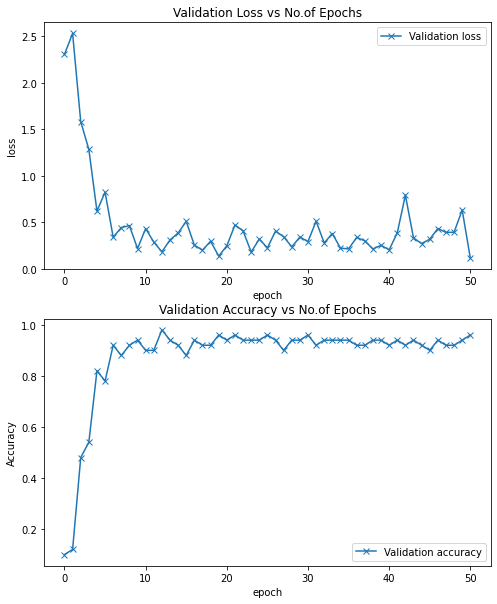

In [ ]:
losses = [x['val_loss'].cpu().data.numpy() for x in history]
accuracy = [x['val_acc'].cpu().data.numpy() for x in history]

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(losses, '-x', label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No.of Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(accuracy, '-x', label="Validation accuracy")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy vs No.of Epochs")
plt.legend()

#### Observation Epoch vs Validation Accuracy Graph
We can observe that the training converges very fast within 10 epochs. After 10 epochs the model toggles between 88% to 96% accuracy, peaking at 98% once.

**Let's analyse performance of model for each digit label**

In [ ]:
# Evaluating accuracy of model for each digit label
num_classes = 10
def evaluate_classes(dataloader, num_classes, model, loss_fn):

    test_correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    for i in range(num_classes):
        print(f'Label: {i} | Accuracy: {(100 * class_correct[i] / class_total[i])}%')
    print(f'Accuracy of the network on all test images: {100 * test_correct/total} %')
    return predicted, c
    
predicted, c = evaluate_classes(val_dataloader, num_classes, model, nn.CrossEntropyLoss())

Label: 0 | Accuracy: 100.0%
Label: 1 | Accuracy: 100.0%
Label: 2 | Accuracy: 80.0%
Label: 3 | Accuracy: 100.0%
Label: 4 | Accuracy: 100.0%
Label: 5 | Accuracy: 100.0%
Label: 6 | Accuracy: 100.0%
Label: 7 | Accuracy: 60.0%
Label: 8 | Accuracy: 100.0%
Label: 9 | Accuracy: 100.0%
Accuracy of the network on all test images: 94.0 %


#### Observation Test Accuracy for each label

The model performs well overall on 50 test images. For label '7', the model is able to accurately predict 3/5. This could also be due to less number of training images for label '7', which might not be enough for AlexNet to learn features. With augmented data, performance improves for label '0' and '8' as compared to baseline AlexNet with no augmneted data.

**Display predictions vs true labels for all test images** 

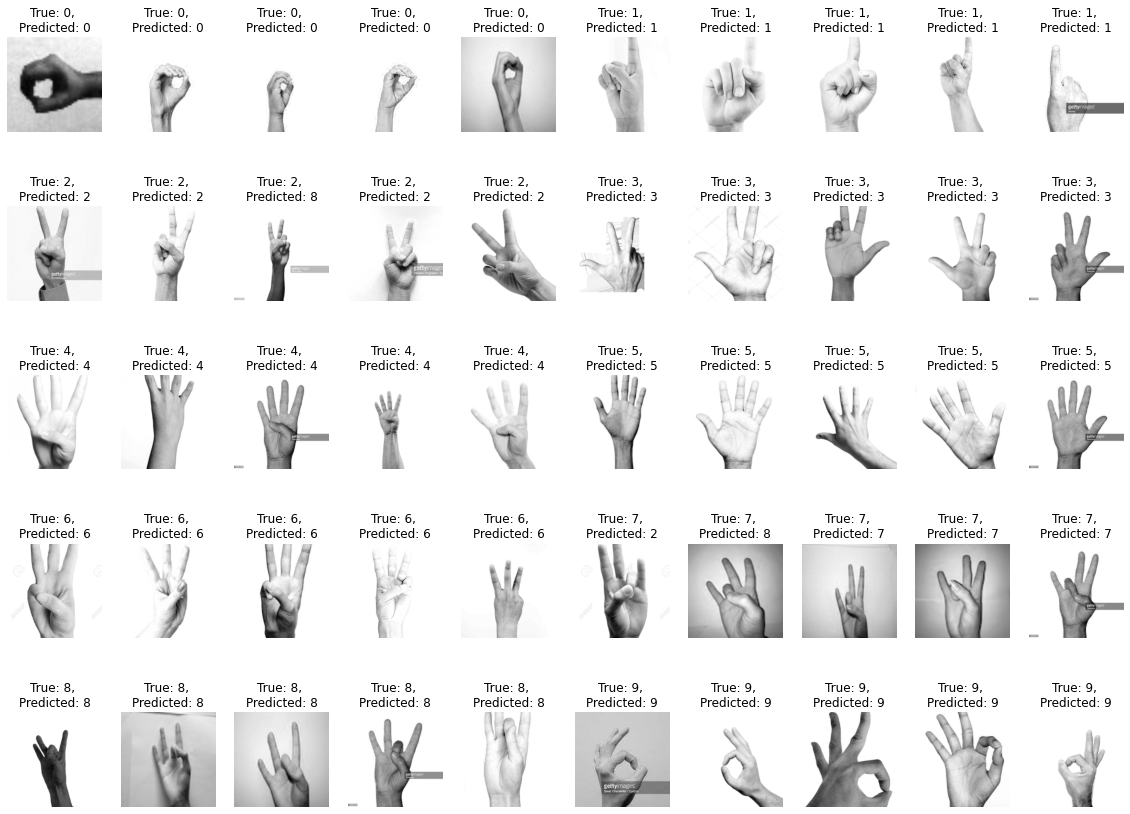

In [ ]:
# create figure
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 5
columns = 10
  
# reading test images
Image = []
for i in range(test_data_size):
    image = image_datasets_test[i][0]
    Image.append(image)

for data in val_dataloader:
    images, true_labels = data
    break

  
# Adds a subplot at the 1st position
for i in range(50):
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(Image[i][0], cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_labels[i].item()}, \nPredicted: {predicted[i].item()}')

### 3.4e) CNN Best Model Architecture and Configurations

AlexNet architecture performs best with 3x224x224 size images and augmented data. Summary of model configurations:

- Augmented Training dataset size: 3360
- Image size: 3x224x224 
- Learning Rate: 0.0001
- Batch Size: 16
- Number of Epochs: 50
- 5 convolutional layers
- 3 fully connected layers
- Dropout, Adaptive Average Pooling
___


# 4. Conclusion

The best model from MLP, RNN and CNN is presented below. The best performing was the AlexNet model with 96% validation accuracy.

AlexNet's better performance can be sttributed to the following:

- Deeper architecture with 8 layers: 5 Conv2D, 3 fully connected
- Overlapping pooling generally find it harder to overfit
- 60M parameters capable of learning more features, also compensated for overfitting by dropout layers and more variety of data through augmentation



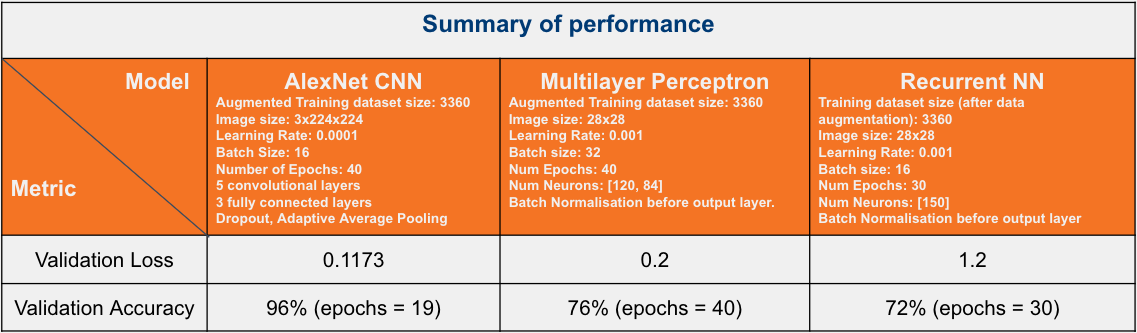

# 5. FUTURE DEVELOPMENTS

1. Combine CNN-LSTM-MLP. CNN on the input, LSTM in the middle and MLP at the output. It can read a sequence of image pixels and generate a prediction.
2. Object Detection to detect the hand and signal
3. Model to detect both the animated hands and human hands

1. Combine CNN-LSTM-MLP. CNN on the input, LSTM in the middle and MLP at the output. It can read a sequence of image pixels and generate a prediction.

___
# 6. REFERENCES:
- [1] World Health Organization on Deafness and hearing loss. Retrieved on 9th October 2022 
- [2] The Singapore Association for the Deaf (SADeaf) Retrieved on 9th October 2022 
- [3] Sign-Speak: Real-time ASL Translation Enabling businesses everywhere to more effectively communicate with their Deaf and Hard of Hearing clients and employees 
- [4] Pugeault, N., and Bowden, R. (2011). Spelling It Out: Real-Time ASL Fingerspelling Recognition In Proceedings of the 1st IEEE Workshop on Consumer Depth Cameras for Computer Vision, jointly with ICCV 
- [5] Joze, H., and Koller, O. (2019) MS-ASL: A Large-Scale Data Set and Benchmark for Understanding American Sign Language, The British Machine Vision Conference (BMVC) 
- [6] Data Source: Google Images 
- [7] Data Source: GettyImages 
- [8] Data Source: iStockPhoto 
- [9] William C. Stokoe, Jr., (2005) Sign Language Structure: An Outline of the Visual Communication Systems of the American Deaf, The Journal of Deaf Studies and Deaf Education, Volume 10, Issue 1, Winter 2005, Pages 3–37 
- [10] Krizhevsky, A, Sutskever, I, and Hinton, G E 2012 ImageNet Classification with Deep Convolutional Neural Networks. In: Pereira, F, Burges, C J C, Bottou, L, and Weinberger, K Q (eds.), Advances in Neural Information Processing Systems 25. Curran Associates, Inc. pp. 1097--1105. Available at http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

<h2><center> Thank you!
